<a href="https://colab.research.google.com/github/GulnazaS/Unet-learning/blob/main/U__net_plus_plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import random
import sys

import skimage.io                                                                     #Used for imshow function
import skimage.transform                                                              #Used for resize function
from skimage.morphology import label                                                  #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
!pip install opendatasets
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Skipping, found downloaded files in "./covid19-radiography-database" (use force=True to force download)


In [ ]:
dataset_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/'

image_dir = 'images'
label_dir = 'masks'

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))            # отображаем картинку
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)  # отображаем маску с прозрачностью 50%
    plt.axis('off')
  plt.show()                                                            # выводим график целиком

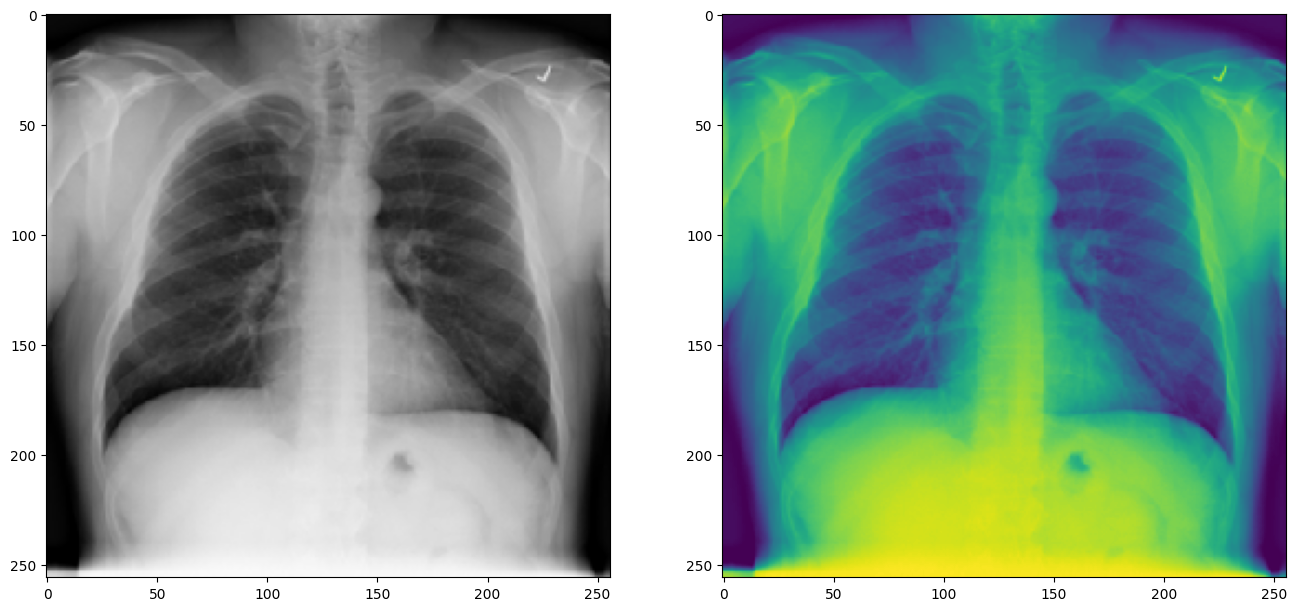

In [ ]:
original_image = os.path.join(dataset_path, image_dir, '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10.png')       # путь до ориганального изображения
label_image_semantic = os.path.join(dataset_path, label_dir, '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10.png') # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # задаем область для построения (канвас)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))   # загружаем оригинальное изображение как RGB с 3 каналами
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))  # загружаем маску как "отеннки серого", т.е. в один канал

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

In [ ]:
input_img_path = sorted([
    os.path.join(dataset_path, image_dir, fname)
    for fname in os.listdir(os.path.join(dataset_path, image_dir))
    if fname.endswith(".png")
])

target_img_path = sorted([
    os.path.join(dataset_path, label_dir, fname)
    for fname in os.listdir(os.path.join(dataset_path, label_dir))
    if fname.endswith(".png")
])

NUM_CLASSES = 3 # число классов берем как число используемых цветов для сегментации (строк), определенные в файле
IMG_SIZE = (256, 256)
img_size = IMG_SIZE
num_classes = NUM_CLASSES
batch_size = 16

In [ ]:
class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path=None, num_classes=NUM_CLASSES, validation=False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.validation = validation

    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size

    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        # Исправлено: правильные размеры массивов
        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")  # 3 канала для изображения
        y = np.zeros((self.batch_size, *self.img_size, num_classes), dtype="uint8")  # num_classes для выходных данных

        for i, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))

            if not self.validation:
                transform = A.Compose([
                    A.Flip(p=0.5),
                    A.RandomRotate90(always_apply=False, p=0.5)
                ])
                transformed = transform(image=img, mask=mask)
                img = transformed["image"]
                mask = transformed["mask"]

            # Убедитесь, что маска преобразована в целочисленный тип и в правильный диапазон значений
            mask = (mask / 255.0 * (num_classes - 1)).astype(np.uint8)
            np.clip(mask, 0, num_classes - 1, out=mask)  # Ограничиваем значения маски

            x[i] = img / 255  # нормализуем изображение
            y[i] = to_categorical(mask, num_classes=num_classes)  # преобразует маску из целых чисел в двоичную матрицу класса

        return x, y

In [ ]:
import random

seed = 1523
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

val_samples = 40

# Расщепим наш датасет  на обучающую и проверочные выборки
train_input_img_path = input_img_path[:-val_samples]
train_target_img_path = target_img_path[:-val_samples]
val_input_img_path = input_img_path[-val_samples:]
val_target_img_path = target_img_path[-val_samples:]

In [ ]:
train_gen = datasetGenerator(batch_size, img_size, train_input_img_path, train_target_img_path, num_classes)
val_gen = datasetGenerator(batch_size, img_size, val_input_img_path, val_target_img_path, num_classes, validation = True)

In [ ]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    acti1 = ReLU()(batch_norm1)


    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = BatchNormalization()(conv2)
    acti2 = ReLU()(batch_norm2)

    return acti2

In [ ]:
# Функция кодировщика
# На входе 2 параметра - предыдущий слой и число фильтров (генерируемых карт признаков)
def encoder(entered_input, filters=64):

    encod1 = convolution_operation(entered_input, filters)  # функция свертки - 2 синих блока
    MaxPool1 = MaxPooling2D(strides = (2,2))(encod1)        # зеленый блок
    return encod1, MaxPool1 # функция возвращает латеральное соединение и выход из слоя

# Функция декодировщика
# На входе 3 параметра - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # красный блок
    Connect_Skip = Concatenate()([Upsample, skip])                                        # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                    # функция свертки - 2 синих блока
    return out # функция возвращает выход из слоя

In [ ]:
# Наша интерпретация модели U-net
def U_Net_plus_plus(img_size, num_classes):
    tf.keras.backend.clear_session()
    nb_filter = [32,64,128,256,512]
    # Build U-Net++ model
    inputs = Input((img_size[0], img_size[1], num_classes))

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.5) (c1)
    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = Dropout(0.5) (c1)
    p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.5) (c2)
    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    c2 = Dropout(0.5) (c2)
    p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
    conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
    c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
    c3 = Dropout(0.5) (c3)
    c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = Dropout(0.5) (c3)

    conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    conv3_1 = Dropout(0.5) (conv3_1)
    conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
    conv3_1 = Dropout(0.5) (conv3_1)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
    conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
    conv2_2 = Dropout(0.5) (conv2_2)
    conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
    conv2_2 = Dropout(0.5) (conv2_2)

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
    conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
    conv1_3 = Dropout(0.5) (conv1_3)
    conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
    conv1_3 = Dropout(0.5) (conv1_3)

    conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
    conv4_1 = Dropout(0.5) (conv4_1)
    conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
    conv4_1 = Dropout(0.5) (conv4_1)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
    conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
    conv3_2 = Dropout(0.5) (conv3_2)
    conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
    conv3_2 = Dropout(0.5) (conv3_2)

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
    conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
    conv2_3 = Dropout(0.5) (conv2_3)
    conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
    conv2_3 = Dropout(0.5) (conv2_3)

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
    conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
    conv1_4 = Dropout(0.5) (conv1_4)
    conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
    conv1_4 = Dropout(0.5) (conv1_4)

    conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
    conv5_1 = Dropout(0.5) (conv5_1)
    conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
    conv5_1 = Dropout(0.5) (conv5_1)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
    conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
    conv4_2 = Dropout(0.5) (conv4_2)
    conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
    conv4_2 = Dropout(0.5) (conv4_2)

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
    conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
    conv3_3 = Dropout(0.5) (conv3_3)
    conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
    conv3_3 = Dropout(0.5) (conv3_3)

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
    conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
    conv2_4 = Dropout(0.5) (conv2_4)
    conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
    conv2_4 = Dropout(0.5) (conv2_4)

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
    conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
    conv1_5 = Dropout(0.5) (conv1_5)
    conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
    conv1_5 = Dropout(0.5) (conv1_5)

    estnet_output_4 = Conv2D(num_classes, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)
    model = Model(inputs, estnet_output_4)
    return model

In [ ]:
num_classes = NUM_CLASSES # 24 класса объектов
input_shape = (IMG_SIZE[0], IMG_SIZE[1], num_classes) # размер к которому преобразуем изображение, 3 канала - RGB
model = U_Net_plus_plus(input_shape, num_classes) # инициализируем модель

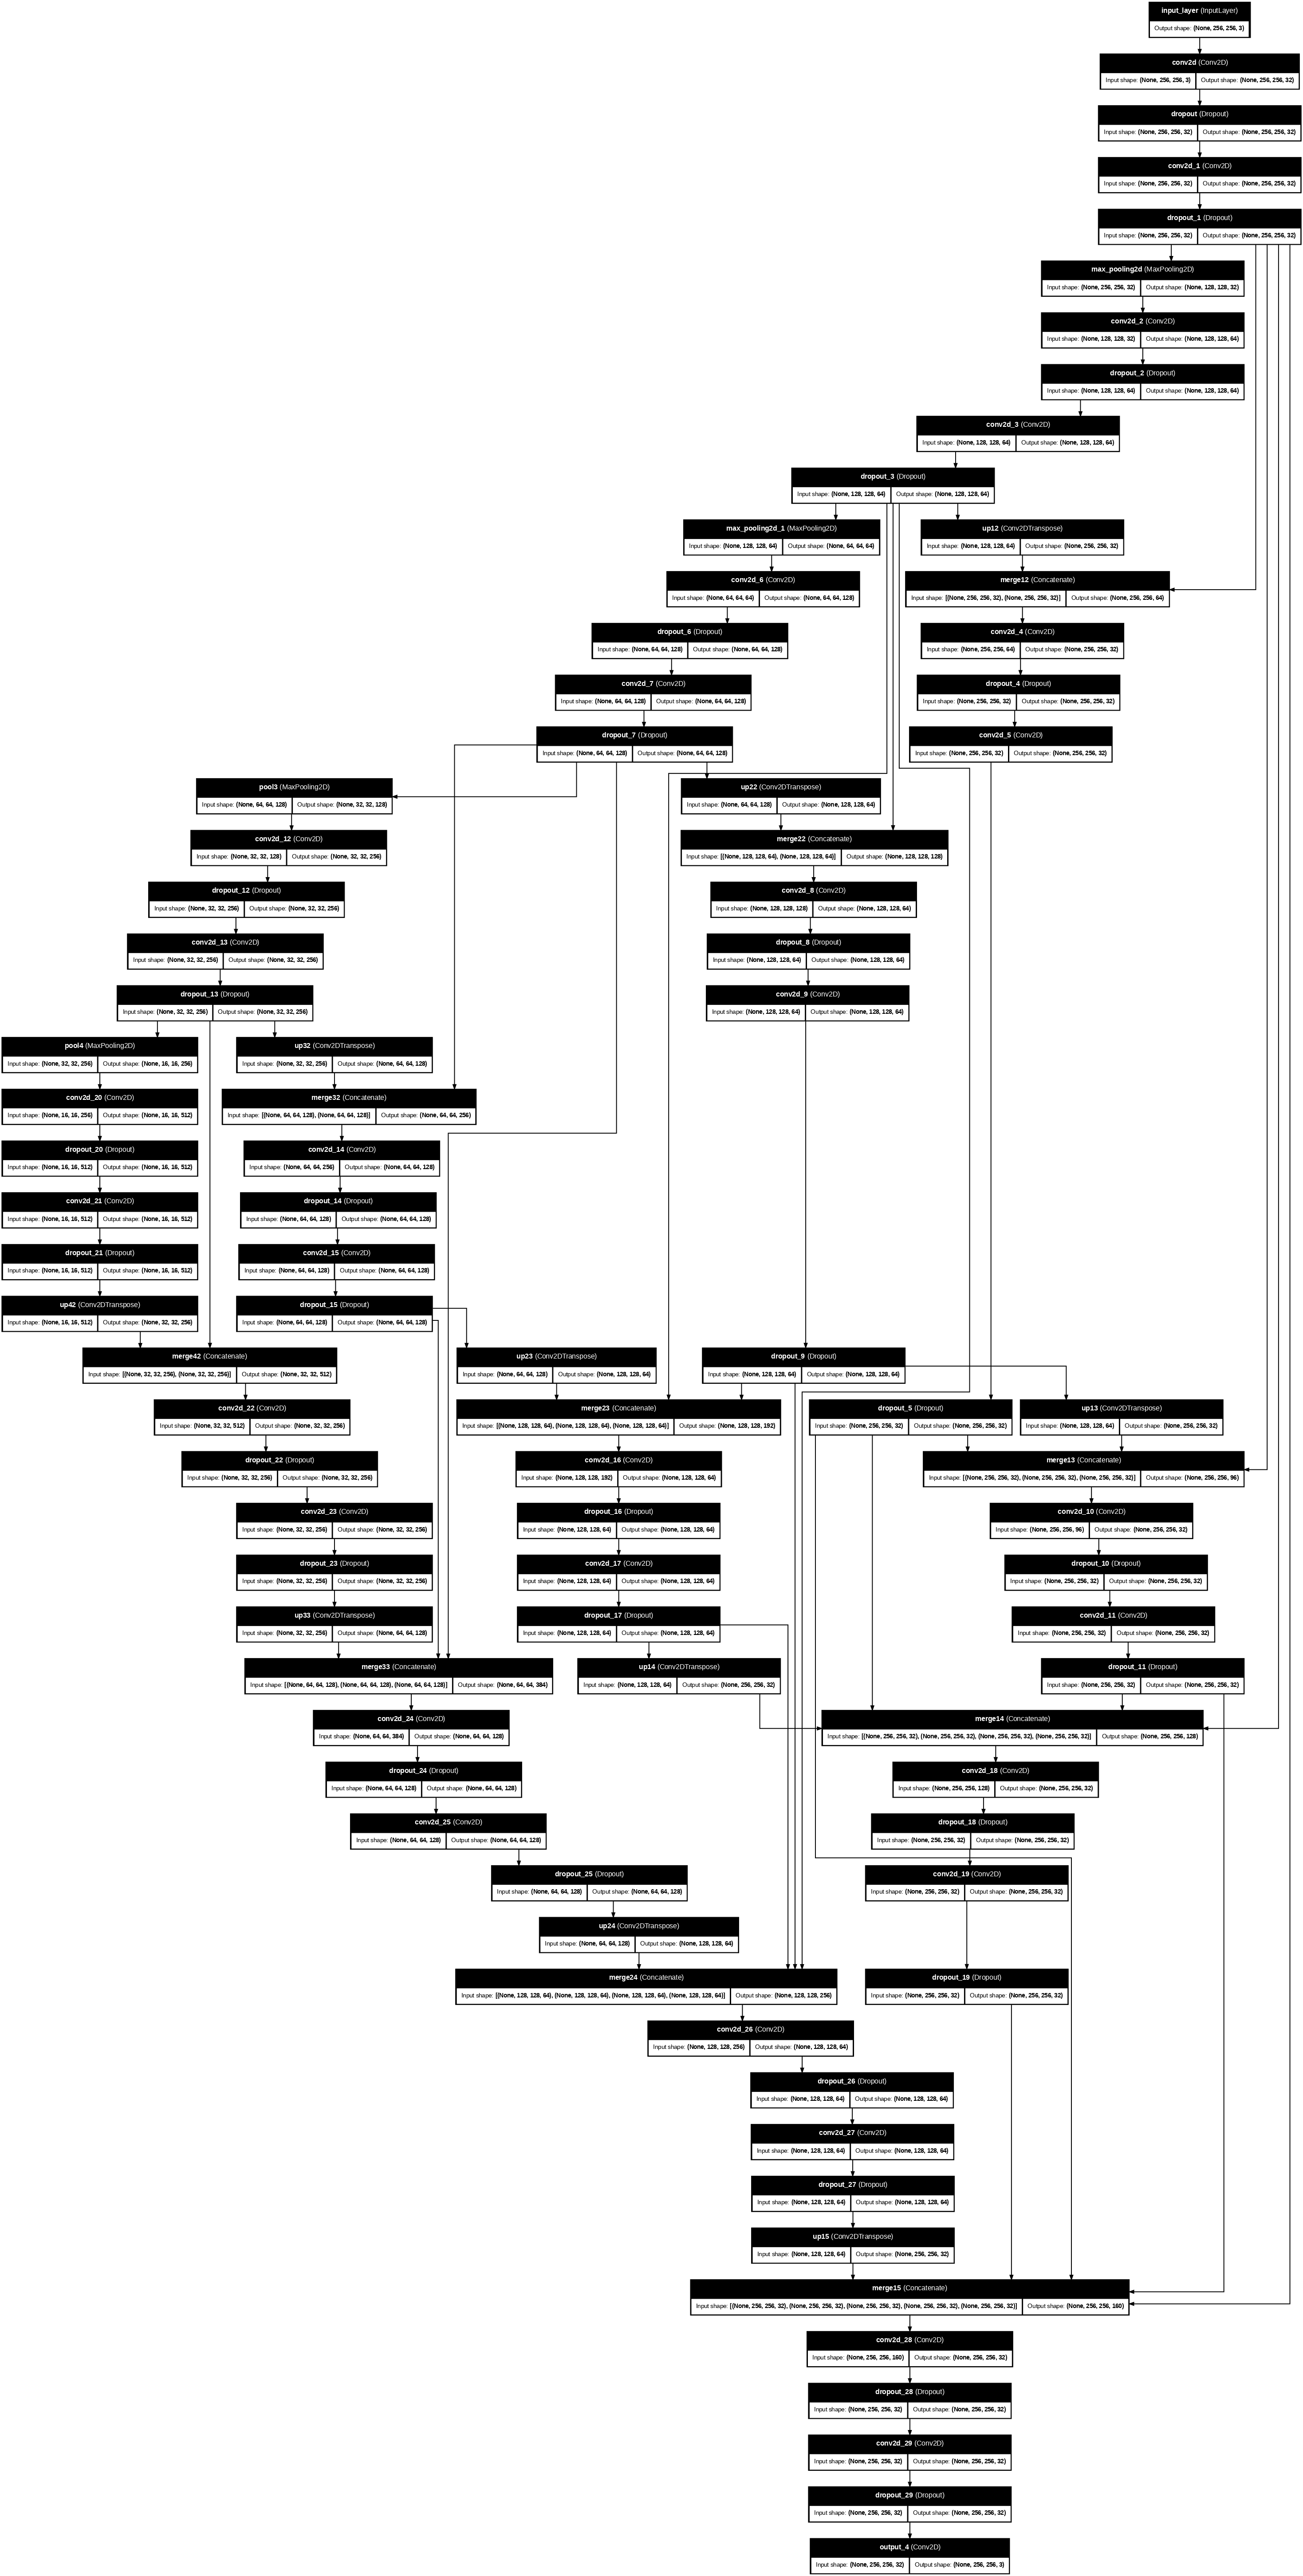

In [ ]:
# график структуры модели
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

In [ ]:
model.summary() # отчет о структуре модели

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 32)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ dropout_3[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool3 (MaxPooling2D)      │ (None, 32, 32, 128)    │              0 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ pool3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 32, 32, 256)    │              0 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)   

 Total params: 9,042,243 (34.49 MB)

 Trainable params: 9,042,243 (34.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Указываем значение learning_rate
learning_rate = 0.0005

# Создаем экземпляр оптимизатора Adam с заданным learning_rate
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True)
]

In [ ]:
epochs = 7
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)

<ipython-input-8-651e79246726>:30: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),


Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


634/634 ━━━━━━━━━━━━━━━━━━━━ 646s 857ms/step - accuracy: 0.7475 - loss: 1.1412 - val_accuracy: 0.7925 - val_loss: 0.9535
Epoch 2/7
634/634 ━━━━━━━━━━━━━━━━━━━━ 601s 864ms/step - accuracy: 0.9505 - loss: 0.1357 - val_accuracy: 0.8210 - val_loss: 1.0930
Epoch 3/7
634/634 ━━━━━━━━━━━━━━━━━━━━ 541s 852ms/step - accuracy: 0.9699 - loss: 0.0817 - val_accuracy: 0.9015 - val_loss: 0.5216
Epoch 4/7
634/634 ━━━━━━━━━━━━━━━━━━━━ 555s 841ms/step - accuracy: 0.9767 - loss: 0.0639 - val_accuracy: 0.9531 - val_loss: 0.2042
Epoch 5/7
634/634 ━━━━━━━━━━━━━━━━━━━━ 561s 839ms/step - accuracy: 0.9805 - loss: 0.0515 - val_accuracy: 0.9702 - val_loss: 0.1428
Epoch 6/7
634/634 ━━━━━━━━━━━━━━━━━━━━ 560s 837ms/step - accuracy: 0.9817 - loss: 0.0453 - val_accuracy: 0.9828 - val_loss: 0.0533
Epoch 7/7
634/634 ━━━━━━━━━━━━━━━━━━━━ 562s 837ms/step - accuracy: 0.9822 - loss: 0.0373 - val_accuracy: 0.9884 - val_loss: 0.0317


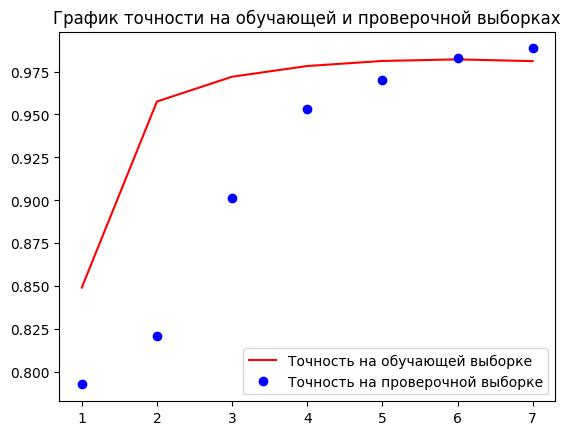

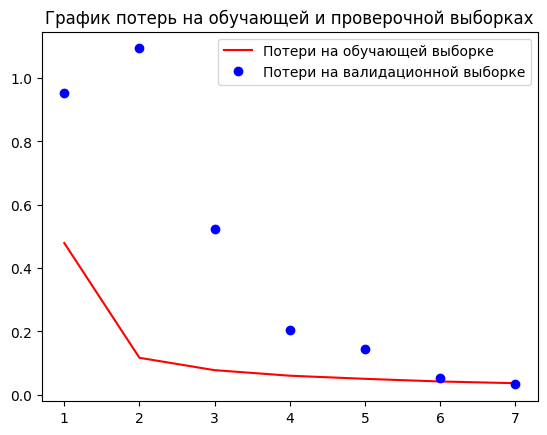

In [ ]:
acc = history.history['accuracy']                                          # данные о точности на обучающей выборке
val_acc = history.history['val_accuracy']                                  # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          # строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   # строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           # заголовок графика
plt.legend()                                                               # легенда графика
plt.figure()                                                               # создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           # строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  # строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             # заголовок графика
plt.legend()                                                               # легенда графика
plt.show()

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0])            # отображаем картинку
    plt.imshow(display_list[i],alpha=0.8)  # отображаем маску с прозрачностью 80%
    plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


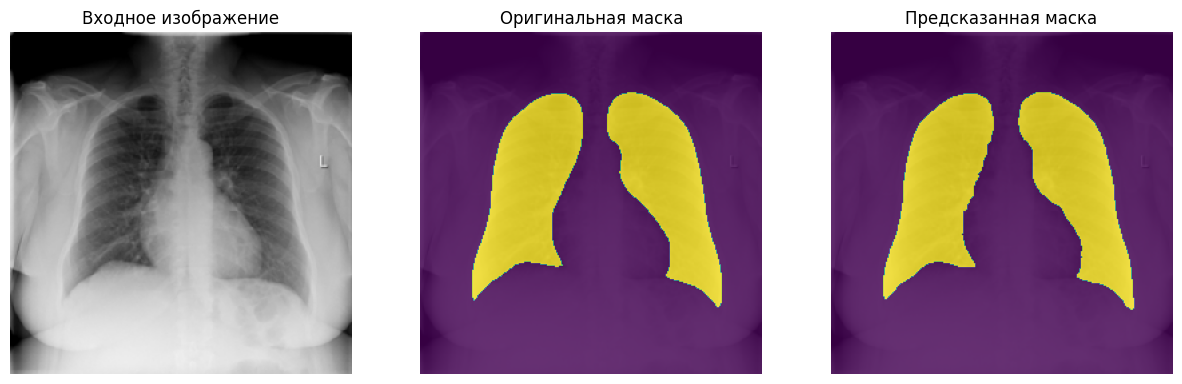

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


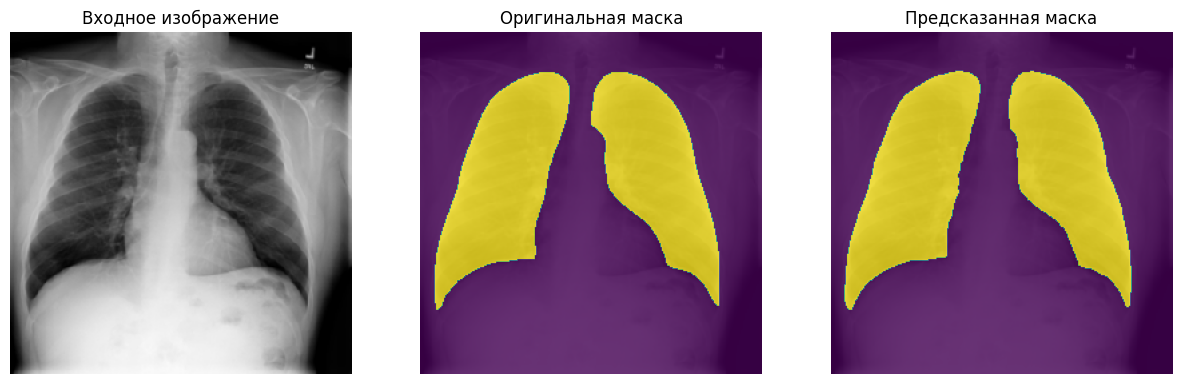

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


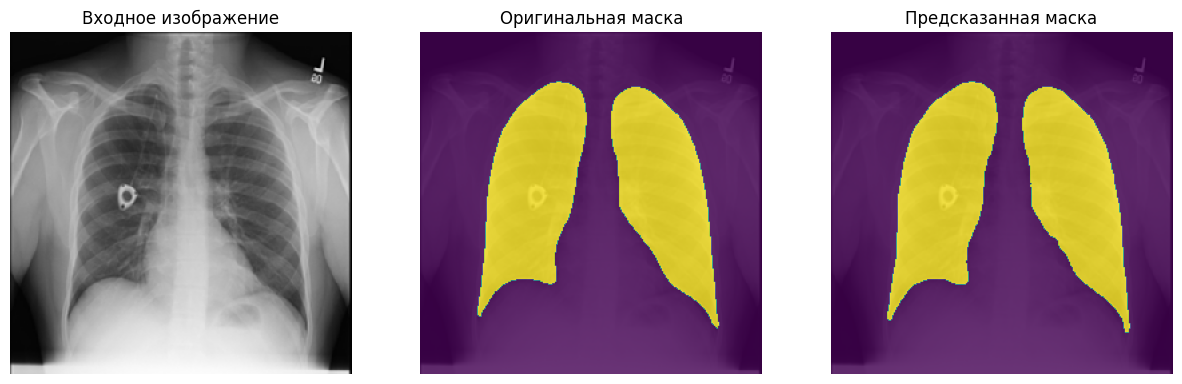

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


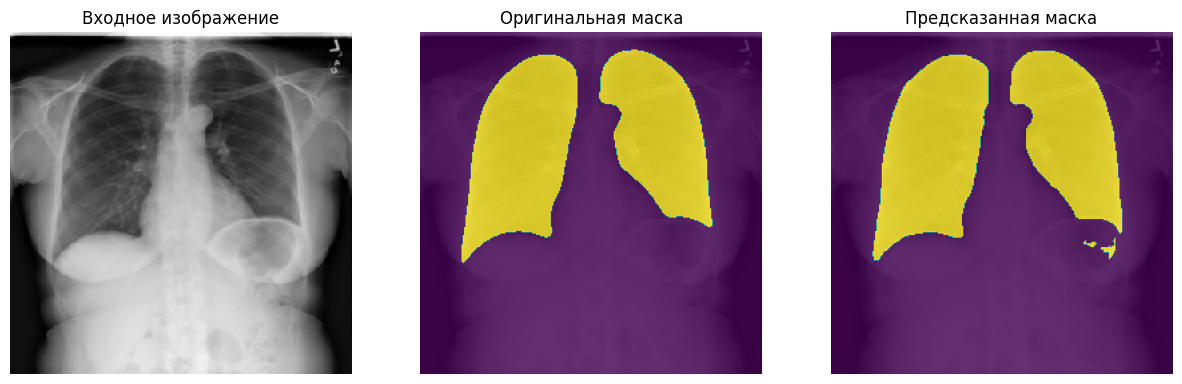

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


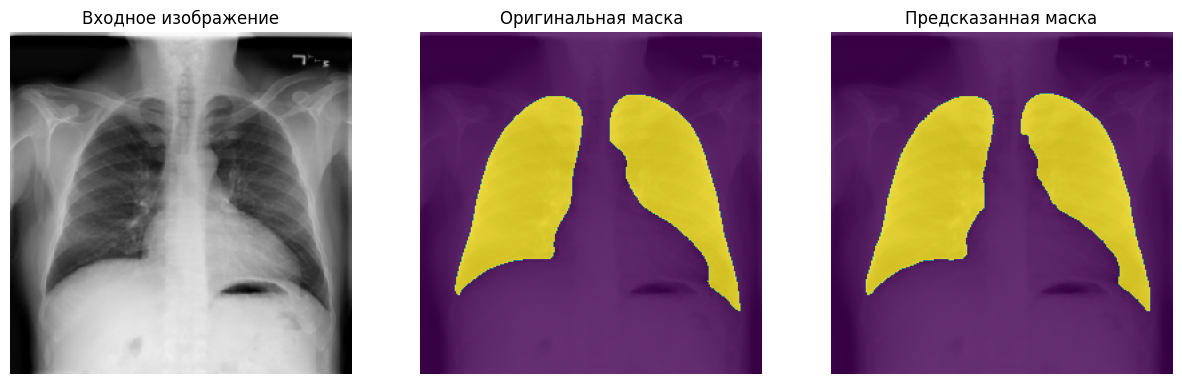

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


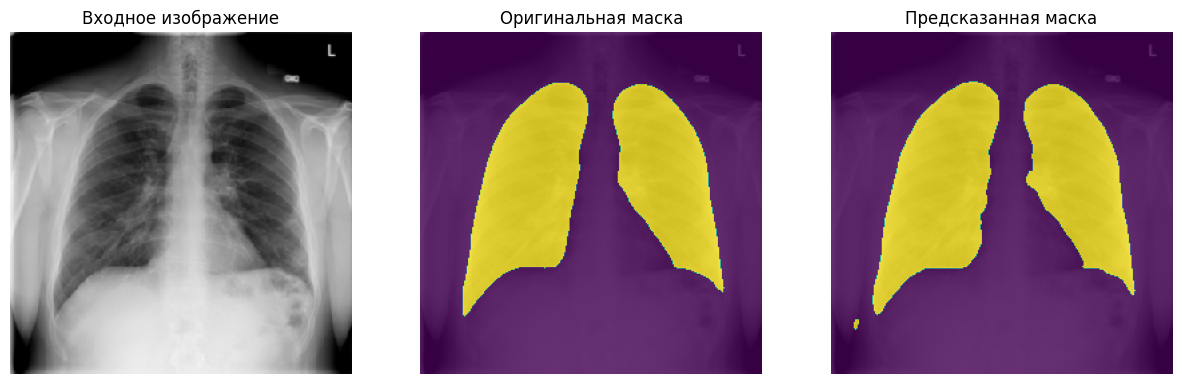

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


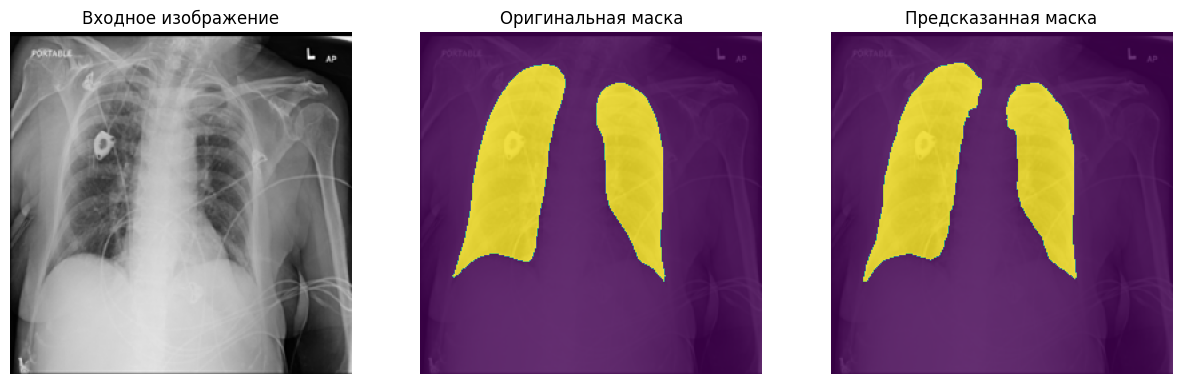

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


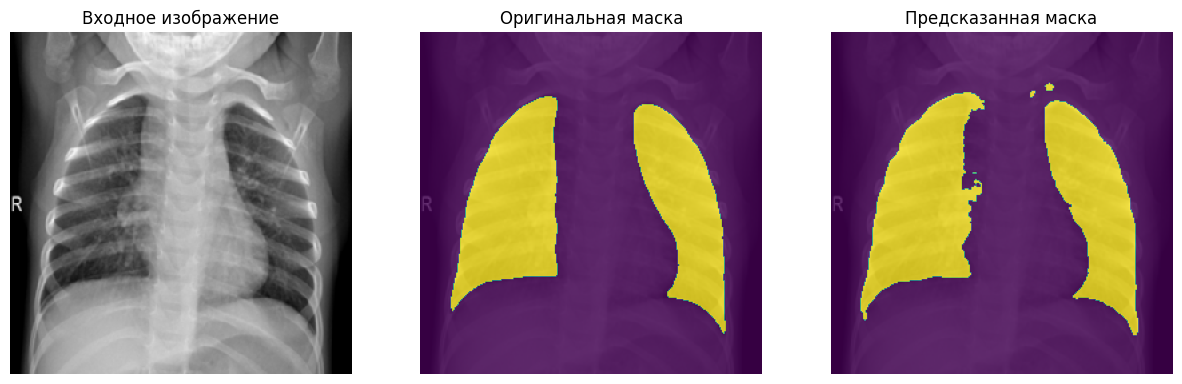

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


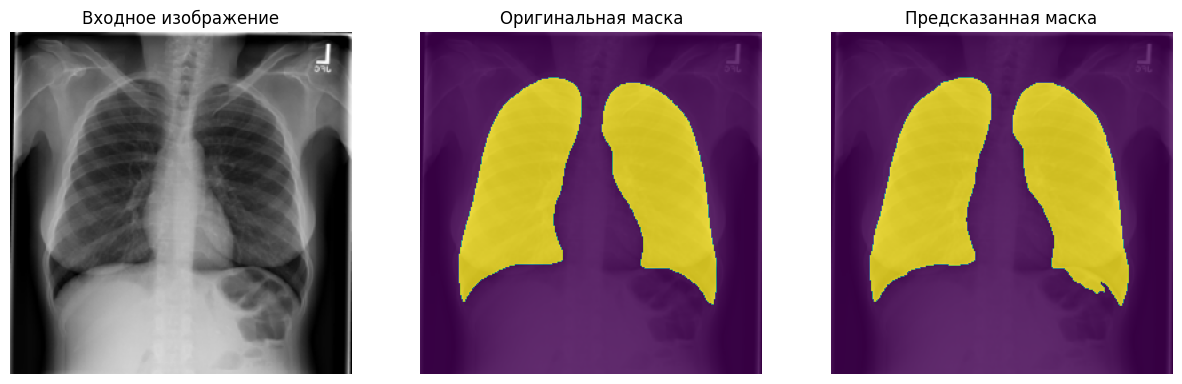

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


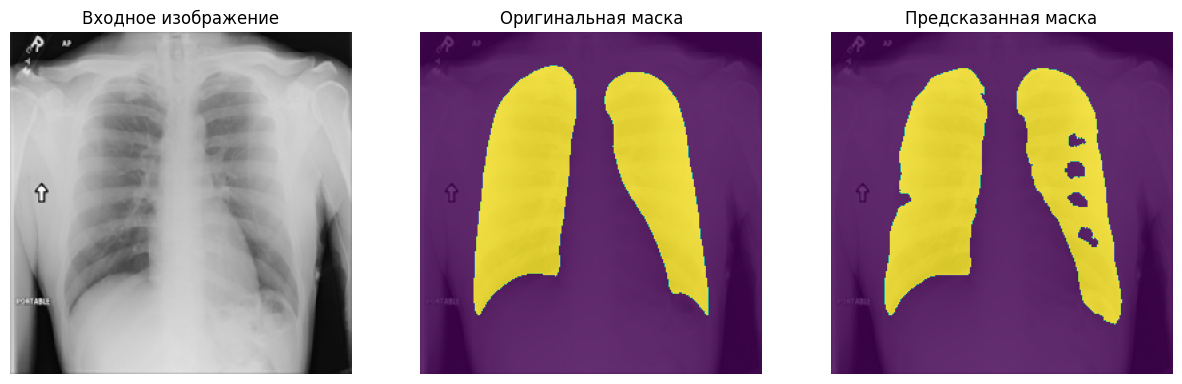

In [ ]:
for index in range(10):                  # выбираем 10 картинок и выводим их в цикле
    img = np.array(load_img(val_input_img_path[index], target_size=(256, 256), color_mode='rgb')) # загружаем картинку для предсказания
    mask = np.array(load_img(val_target_img_path[index], target_size=(256, 256), color_mode='grayscale')) # загружаем маску для сравнения с предсказанием

    # Запускаем модель в режиме предсказания
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Выбираем наиболее веротный класс
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 256, 256, 3)[0], mask, test[0]])  # передаем в функцию display изображение, оригинальную маску и предсказанную